# Proximal Policy Optimization

# Introduction
This is an implementation of the Proximal Policy Optimization (PPO) algorithm, an on-policy reinforcement learning algorithm that is stable and practical, hence widely used in reinforcement learning applications. In particular, the following are implemented:

1.   Actor and Critic network
2.   Truncated Generalized  Advantage Estimation
3.   Clipped surrogate loss function

Reference:
Schulman, John, et al. "Proximal Policy Optimization Algorithms." [arXiv preprint arXiv:1707.06347](https://arxiv.org/abs/1707.06347) (2017).

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = ''
assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive/$FOLDERNAME
!mkdir saved_model
!mkdir test_video

In [18]:
!pip install gymnasium

In [19]:
import random
import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import categorical

## Hyperparameters

In [ ]:
# Hyperparameters
seed = 1207
env_id = "CartPole-v1"
total_frames = 500000
num_envs = 4
num_steps = 128
num_minibatches = 4

learning_rate = 2.5e-4
gamma = 0.99
gae_lambda = 0.95
update_epochs = 4
clip_coeff = 0.2
entropy_coeff = 0.01
value_coeff = 0.5
max_grad_norm = 0.5

In [ ]:
batch_size = int(num_envs * num_steps)
minibatch_size = int(batch_size // num_minibatches)
num_iterations = total_frames // batch_size

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# make environment
def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env

    return thunk

envs = gym.vector.SyncVectorEnv([make_env(env_id) for i in range(num_envs)])

action_shape = 2
obs_shape = envs.single_observation_space.shape[0]

## Actor-Critic

In the policy gradient method, the Actor-Critic framework is important in enhancing training stability and effectiveness. \
This approach is based on a two-part: the 'Actor', responsible for choosing actions according to the existing policy, and the 'Critic', which assesses current states by determining the value of each state. \
The key idea is to use the critic as a baseline to evaluate the action of policy: \
> Instead of optimizing the policy to maximize the return, it penalizes the action from a policy that gives less return compared to the baseline; aka the advantage function. Further insight can be found in this tutorial: [video](https://www.youtube.com/watch?v=AKbX1Zvo7r8&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=3).

First, I create a the value function approximato0r by parameterizing it into a Multi-Layer Perceptron (MLP). \\ The hidden layer shape, initialization gain, and activation functions are probably not optimal, but were slightly turned to get better results.

In [ ]:
# Structure of network architecture. You may change this architecture size
actor_hidden_layers = [64,64]
critic_hidden_layers = [64,64]
activation_fn = nn.Tanh
critic_network_initialization_gain = [np.sqrt(2), np.sqrt(2), 1.0]
actor_network_initialization_gain = [np.sqrt(2), np.sqrt(2), 0.01]

# Actor Critic
class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        # critic architecture
        self.critic = nn.Sequential(
              nn.Linear(obs_shape, critic_hidden_layers[0]),
              nn.Tanh(),
              nn.Linear(critic_hidden_layers[0], critic_hidden_layers[1]),
              nn.Tanh(),
              nn.Linear(critic_hidden_layers[1], 1)
            )
        # this initialize the weight with 0 bias
        itr = 0
        for layer in self.critic:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, critic_network_initialization_gain[itr])
                torch.nn.init.constant_(layer.bias, 0)
                itr+=1

        # actor architecture
        self.actor = nn.Sequential(
            nn.Linear(obs_shape, actor_hidden_layers[0]),
            nn.Tanh(),
            nn.Linear(actor_hidden_layers[0], actor_hidden_layers[1]),
            nn.Tanh(),
            nn.Linear(actor_hidden_layers[1], action_shape)
          )
        # this initialize the weight with 0 bias
        itr = 0
        for layer in self.actor:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, actor_network_initialization_gain[itr])
                torch.nn.init.constant_(layer.bias, 0)
                itr+=1

    def get_value(self, value_obs):
        return self.critic(value_obs)

    def get_action(self, actor_obs):
        ''' used for roll-out '''
        logits = self.actor(actor_obs)
        probs = categorical.Categorical(logits=logits)
        action = probs.sample()
        return action, probs.log_prob(action)

    def action_evaluate(self, actor_obs, action):
        ''' used for evaluation and loss computation '''
        logits = self.actor(actor_obs)
        probs = categorical.Categorical(logits=logits)
        return probs.log_prob(action), probs.entropy()


In [24]:
# Instantiate Actor-Critic networks
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)

# buffers for training
obs = torch.zeros((num_steps, num_envs, obs_shape)).to(device)
actions = torch.zeros((num_steps, num_envs)).to(device)
log_probs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)

## Generalized Advantage Estimation (GAE)

Here is an implementation of the *modified* GAE introduced in the PPO paper which is the finite trimmed version of the original GAE.

Hopefully the reader is familiar with the advantage function, defined as
$$
A^\pi(s, a) = Q^\pi(s,a) - V^\pi(s)
$$
Here, $Q^\pi(s,a)$ is the action-value function which represents the expected return of taking action $a$ in state $s$ and thereafter following policy. On the other hand, $V^\pi(s)$ is the value function representing the expected return of the following policy from state $s$. The relation between Q-function and the value function is
$$V^\pi(s) = E_{a \sim \pi(.|s)}[Q^\pi(s,a)]$$
The advantage function thus represents the difference between the expected return of taking a specific action and the expected return of the policy's average action. If $A^\pi(s,a)$ is positive, it means that action $a$ is better than the policy's average action for that state. Conversely, if it's negative, the action is worse than average.

In order to estimate this advantage function, we need to estimate the expected return given state and action pair. There are several ways to estimate this value including Monte Carlo estimation and one-step lookahead bootstrapping. To express this, let's write down some of the estimations here, \\
\begin{align*}
Q^{\pi}(s, a) &= \mathbb{E}[r_0 + \gamma r_1 + \gamma^2 r_2 + \ldots | s_0 = s, u_0 = u] \\
&= \mathbb{E}[r_0 + \gamma V^{\pi}(s_1) | s_0 = s, u_0 = u] \\
&= \mathbb{E}[r_0 + \gamma r_1 + \gamma^2 V^{\pi}(s_2) | s_0 = s, u_0 = u] \\
&= \mathbb{E}[r_0 + \gamma r_1 + \gamma^2 r_2 + \gamma^3 V^{\pi}(s_3) | s_0 = s, u_0 = u] \\
&= \; ...
\end{align*} \\
As we get closer to the Monte Carlo estimation, we can obtain a less biased estimate but more variance and vice versa. \\
Generalized Advantage Estimation (GAE) balances this bias-variance trade-off by a technique known as eligibility traces, allowing for an adjustable parameter $\lambda$ to control the trade-off in the advantage estimates.  \\
Mathematically, GAE can be described as follows:  \\
For each advantage estimation using temporal difference,
\begin{align*}
A^{(1)}_t &= \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) \\
A^{(2)}_t &= \delta_t + \gamma \delta_{t+1} = r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) - V(s_t) \\
A^{(3)}_t &= \delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 V(s_{t+3}) - V(s_t) \\
...
\end{align*}

Generalized Advantage Estimation (GAE) is the exponentially-weighted average of n-step estimators which can be written as:

\begin{align*}
A^{GAE(\gamma, \lambda)}_t &= (1 - \lambda)(\lambda A^{(1)}_t + \lambda^2 A^{(2)}_t + \ldots) \\
&= (1 - \lambda)(\delta_t + \lambda(\gamma \delta_{t+1} + \lambda(\gamma^2 \delta_{t+2} + \ldots ))) \\
&= (1 - \lambda)(\delta_t + \lambda \gamma \delta_{t+1} + \lambda^2 \gamma^2 \delta_{t+2} + \ldots ) \\
&= (1 - \lambda)(\delta_t(1 + \lambda \gamma + \lambda^2 \gamma^2 + \ldots) + \gamma \lambda \delta_{t+1}(1 + \lambda \gamma + \lambda^2 \gamma^2 + \ldots) + \ldots) \\
&= (1 - \lambda)(\delta_t \frac{1}{1 - \lambda \gamma} + \gamma \lambda \delta_{t+1} \frac{\lambda}{1 - \lambda \gamma} + \ldots) \\
&= \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}
\end{align*}

Lastly, in PPO, $A^{GAE(\gamma, \lambda)}_t$ is trimmed to finite sum upto the step length used to collecting trajectories.
$$ A^{GAE(\gamma, \lambda)}_t = \sum_{l=0}^{T} (\gamma \lambda)^l \delta_{t+l} $$

[High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438)
Schulman, John, et al. ICLR, 2016.

Here we estimate the expected return by
$$\text{Return} = \hat{A}(s,a)+V^\pi(s)$$

To compute GAE estimate, we are going to start computing from the last advantage estimate $\hat{A}_T$ and reuse it to compute the earlier advantage estimates $\hat{A}_{T-1}, \hat{A}_{T-2}, ... \hat{A}_1$.

More specifically,
$$
\delta_t = r_t+(1-\text{done}_{t+1}) \cdot \gamma \cdot V^\pi(s_{t+1})-V^\pi(s_t)   \\
\hat{A}_t = \delta_t + \gamma \cdot \lambda \cdot (1-\text{done}_{t+1}) \cdot \hat{A}_{t+1}
$$
For $\lambda$, the variable *gae_lambda* is defined, and for $\gamma$, the variable *gamma* is defined.



In [ ]:
def compute_gae_return(last_obs, rewards, last_done, dones, values):
    '''
    Args:
        last_obs: last observation of roll out. shape: (num_envs, obs_size)
        rewards: all the rewards throughout the trajectrory. shape: (num_steps, num_envs)
        last_done: Boolean to indicate if the last state was terminal or not. shape: (num_envs)
        dones: Boolean to indicate if each step was terminated or not throughout the trajectory. shape: (num_steps, num_envs)
        values: all the values computed by Critic(s) throughout the trajectory. shape (num_steps, num_envs)
    '''
    with torch.no_grad():
        next_values = agent.get_value(last_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        last_advantage = 0

        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                next_terminated = last_done
                next_values = next_values
            else:
                next_terminated = dones[t + 1]
                next_values = values[t + 1]
            # truncated gae
            temporal_difference = rewards[t] + (1 - next_terminated) * gamma * next_values - values[t]

            # Update last_advantage for the current timestep
            last_advantage = temporal_difference + gamma * gae_lambda * (1 - next_terminated) * last_advantage
            advantages[t] = last_advantage
        returns = advantages + values

        # advantage normalization
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return returns, advantages

## Policy Loss
PPO is essentially an on-policy algorithm that collects new data with every update. However, for efficient and stable learning purposes, the policy is updated using the same batch of data several times. This requires the loss function to be recomputed using importance sampling. This "surrogate loss function" is given as follows:

$$
r(\theta) = \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}
$$

$$
L(\theta) = \mathbb{\hat{E}}_t \left[ r(\theta)A^{\theta_{old}}_t \right]
$$

Maximizing this objective without constraining the ratio can lead to excessively large updates. In [Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477), the old and current policies are constrained to be close enough through the measurement of Kullback-Leibler divergence. Of course that comes with its own host of issues (schulman speaks to this in one of the deep rl bootcamp videos, i can't remember what it is right now but definitely a good read )
In PPO, it is implemented more practically by clipping the probability ratio between the new and old policies: 

$$
L^{CLIP}(\theta) = \mathbb{\hat{E}}_t \left[ \min(r(\theta)A^{\theta_{old}}_t, \text{clip}(r(\theta), 1 - \epsilon, 1 + \epsilon)A^{\theta_{old}}_t) \right]
$$

Here, $\epsilon$ is a hyperparameter that defines the clipping range, and is given by the  clip_coeff variable \\

In [ ]:
def compute_surrogate_loss(curr_log_probs_mini_batch, log_probs_mini_batch, advantages_mini_batch):
    '''
    Args:
        curr_log_probs_mini_batch: log probability of current policy on observation mini-batch. shape: (num_steps)
        log_probs_mini_batch: log probability of old policy on observation mini-batch. shape: (num_steps)
        advantages_mini_batch: mini-batch of advantages of old policy. shape (num_steps)
    '''
    log_probs_ratio_mini_batch = torch.exp(curr_log_probs_mini_batch) / torch.exp(log_probs_mini_batch)
    surrogate_loss = -torch.mean(
        torch.minimum(
            log_probs_ratio_mini_batch * advantages_mini_batch,
            torch.clamp(log_probs_ratio_mini_batch, min=1-clip_coeff, max=1+clip_coeff) * advantages_mini_batch
          ),
        )

    return surrogate_loss

## Rollout and Training
Finally, we roll-out the trajectories and train the policy based on on-policy data!

In [27]:
def compute_clipped_value_loss(new_values, returns_mini_batch, values_mini_batch):
    ''' value loss but in clipped version for training stability '''
    value_loss_unclipped = (new_values - returns_mini_batch) ** 2
    clipped_value = values_mini_batch + torch.clamp(
        new_values - values_mini_batch,
        -clip_coeff,
        clip_coeff,
    )
    value_loss_clipped = (clipped_value - returns_mini_batch) ** 2
    value_loss = torch.max(value_loss_unclipped, value_loss_clipped)
    return 0.5 * value_loss.mean()

def compute_entropy_loss(entropy):
    return entropy.mean()

def aggregate_losses(surrogate_loss, value_loss, entropy_loss):
    return surrogate_loss - entropy_coeff * entropy_loss + value_coeff * value_loss

In [28]:
# reset the environment
next_obs, _ = envs.reset(seed=seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(num_envs).to(device)

# episodit data buffer for logging
episodic_return = {"eps_return": [], "frame_count": []}
episodic_length = {"eps_length": [], "frame_count": []}

# for data log
learning_rate_logs = []
value_loss_logs = []
surrogate_loss_logs = []
entropy_loss_logs = []
num_frames_log = []
frame_count = 0

for itr in range(1, num_iterations + 1):
    optimizer.param_groups[0]["lr"] = (1.0 - (itr - 1) / num_iterations) * learning_rate
    # Roll-out
    for step in range(num_steps):
        frame_count += num_envs
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, logprob = agent.get_action(next_obs)
            value = agent.get_value(next_obs)
        actions[step] = action
        log_probs[step] = logprob
        values[step] = value.flatten()

        next_obs, reward, terminations, timeouts, step_infos = envs.step(action.detach().cpu().numpy())
        next_done = np.logical_or(terminations, timeouts)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        # print episodic information.
        if "final_info" in step_infos:
            for step_info in step_infos["final_info"]:
                if step_info and "episode" in step_info:
                    episodic_return["eps_return"].append(step_info["episode"]["r"])
                    episodic_length["eps_length"].append(step_info["episode"]["l"])
                    episodic_return["frame_count"].append(frame_count)
                    episodic_length["frame_count"].append(frame_count)
                    print(f"frame_count={frame_count}, episodic_return={step_info['episode']['r']}, episodic_length={step_info['episode']['l']}")

    # compute the returns and advantages of the trajectories
    returns, advantages = compute_gae_return(next_obs, rewards, next_done, dones, values)

    # flatten the batch to (num_steps * num_envs, feature_shape)
    obs_batch = obs.reshape((-1,obs_shape))
    actions_batch = actions.reshape((-1,))
    log_probs_batch = log_probs.reshape(-1)
    advantages_batch = advantages.reshape(-1)
    returns_batch = returns.reshape(-1)
    values_batch = values.reshape(-1)

    # Train actor and critic network
    inds_batch = np.arange(batch_size)
    for epoch in range(update_epochs):
        np.random.shuffle(inds_batch)
        inds_mini_batches = [inds_batch[i:i + minibatch_size] for i in range(0, batch_size, minibatch_size)]
        # mini-batch gradient descent
        for inds_mini_batch in inds_mini_batches:
            curr_log_probs, entropy = agent.action_evaluate(obs_batch[inds_mini_batch], actions_batch.long()[inds_mini_batch])
            new_value = agent.get_value(obs_batch[inds_mini_batch]).view(-1)

            surrogate_loss = compute_surrogate_loss(curr_log_probs, log_probs_batch[inds_mini_batch], advantages_batch[inds_mini_batch])

            v_loss = compute_clipped_value_loss(new_value, returns_batch[inds_mini_batch], values_batch[inds_mini_batch])

            entropy_loss = compute_entropy_loss(entropy)

            loss = aggregate_losses(surrogate_loss, v_loss, entropy_loss)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

    # Record rewards for plotting purposes
    learning_rate_logs.append(optimizer.param_groups[0]["lr"])
    value_loss_logs.append(v_loss.item())
    surrogate_loss_logs.append(surrogate_loss.item())
    entropy_loss_logs.append(entropy_loss.item())
    num_frames_log.append(frame_count)

envs.close()

frame_count=32, episodic_return=[8.], episodic_length=[8]
frame_count=48, episodic_return=[12.], episodic_length=[12]
frame_count=64, episodic_return=[16.], episodic_length=[16]
frame_count=88, episodic_return=[22.], episodic_length=[22]
frame_count=112, episodic_return=[12.], episodic_length=[12]
frame_count=128, episodic_return=[10.], episodic_length=[10]
frame_count=164, episodic_return=[29.], episodic_length=[29]
frame_count=180, episodic_return=[13.], episodic_length=[13]
frame_count=232, episodic_return=[17.], episodic_length=[17]
frame_count=256, episodic_return=[19.], episodic_length=[19]
frame_count=276, episodic_return=[41.], episodic_length=[41]
frame_count=340, episodic_return=[21.], episodic_length=[21]
frame_count=352, episodic_return=[19.], episodic_length=[19]
frame_count=356, episodic_return=[81.], episodic_length=[81]
frame_count=396, episodic_return=[41.], episodic_length=[41]
frame_count=396, episodic_return=[11.], episodic_length=[11]
frame_count=404, episodic_retu

## Evaluation

model saved to saved_model/trained_model.pth


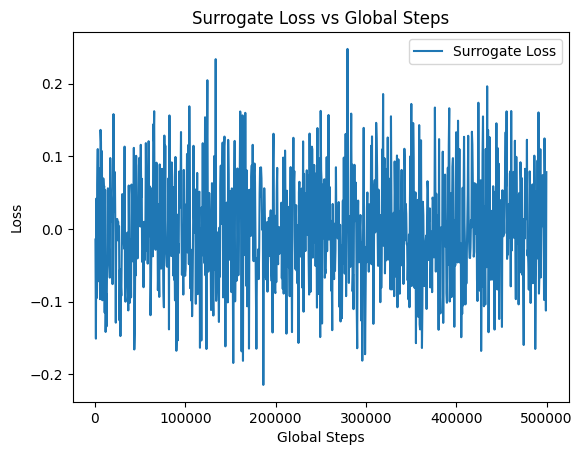

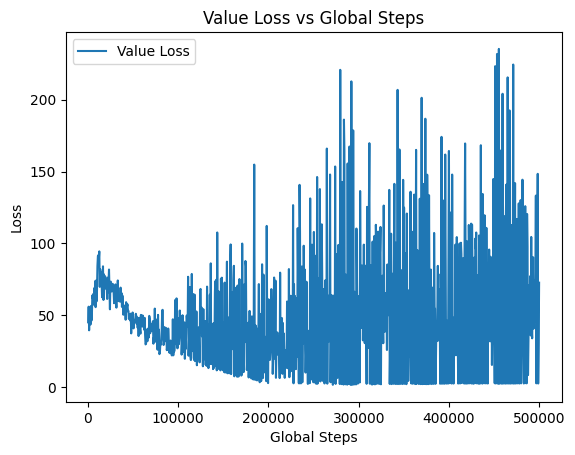

In [29]:
# save model
model_path = f"saved_model/trained_model.pth"
torch.save(agent.state_dict(), model_path)
print(f"model saved to {model_path}")

import matplotlib.pyplot as plt

# Plotting the graph
# plt.plot(global_steps_log, learning_rate_logs, label='Learning Rate')
plt.plot(num_frames_log, surrogate_loss_logs, label='Surrogate Loss')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.title('Surrogate Loss vs Global Steps')
plt.legend()
plt.show()

plt.plot(num_frames_log, value_loss_logs, label='Value Loss')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.title('Value Loss vs Global Steps')
plt.legend()
plt.show()


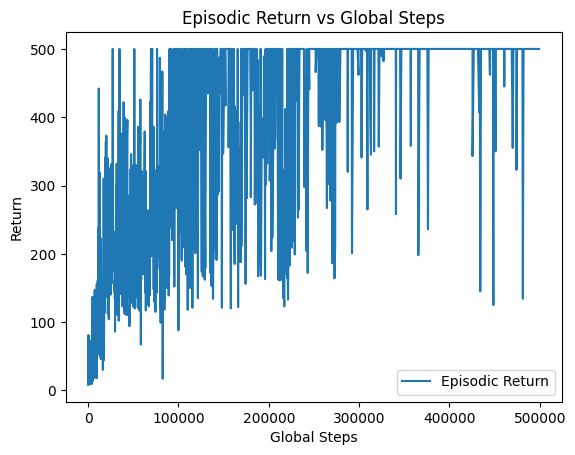

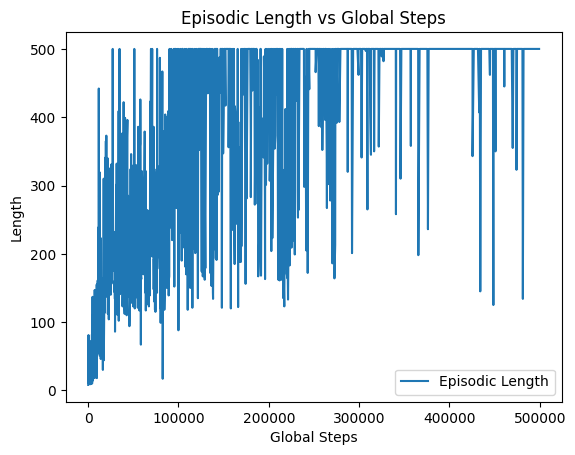

In [ ]:

# plt.plot(global_steps_log, entropy_loss_logs, label='Entropy Loss')
plt.plot(episodic_return["frame_count"], episodic_return['eps_return'], label='Episodic Return')
plt.xlabel('Global Steps')
plt.ylabel('Return')
plt.title('Episodic Return vs Global Steps')
plt.legend()
plt.show()

plt.plot(episodic_length["frame_count"], episodic_length['eps_length'], label='Episodic Length')
plt.xlabel('Global Steps')
plt.ylabel('Length')
plt.title('Episodic Length vs Global Steps')
plt.legend()
plt.show()

In [ ]:
# test trained model
# make environment
def make_test_env(env_id):
    def thunk():
        env = gym.make(env_id, render_mode='rgb_array')
        env = gym.wrappers.RecordVideo(env, "test_video")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env

    return thunk

envs = gym.vector.SyncVectorEnv([make_test_env(env_id)])
agent = Agent(envs).to(device)
agent.load_state_dict(torch.load(model_path, map_location=device))
agent.eval()

obs, _ = envs.reset()
obs, _ = envs.reset()
episodic_returns = []
while len(episodic_returns) < 10:
    actions, _ = agent.get_action(torch.Tensor(obs).to(device))
    next_obs, _, _, _, infos = envs.step(actions.cpu().numpy())
    if "final_info" in infos:
        for info in infos["final_info"]:
            if "episode" not in info:
                continue
            print(f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}")
            episodic_returns += [info["episode"]["r"]]
    obs = next_obs
plt.plot(episodic_returns)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Episodic Return vs Episodes')
plt.show()